## **OptimESM EC-Earth RAPID 26.5N Validation**

### **Description**

Validation of EC-Earth esm-hist (1850-2014) RAPID 26.5N AMOC diagniostics calculated using the Meridional ovErTurning ciRculation diagnostIC (METRIC) package.

### **Created By:**

Ollie Tooth, National Oceanography Centre (oliver.tooth@noc.ac.ul)

In [1]:
# -- Import dependencies -- #
import glob
import numpy as np
import xarray as xr
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm

In [2]:
# -------------------------------------------------------------------
# SETTINGS: global figure style for Nature-style publications
# -------------------------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.linewidth": 0.8,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.top": False,
    "ytick.right": False,
})

### **Prepare EC-Earth RAPID 26.5N outputs**

In [3]:
# === Process historical (1850-2014) ensemble members: RAPID AMOC Diagnostics === #
# Define path to files:
filepaths = []
filedir = "/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP4/data"
for n, inst in enumerate(["CNR", "BSC", "DMI", "ULUND", "SMHI"]):
    filepaths.append(f"{filedir}/{inst}/EC-Earth3-ESM-1_esm-hist_r{n+1}i1p1f1_1850-01-2014-12_natl_meridional_transports_at_26N.nc")

members = np.arange(5)
ds_list = []
for member in members:
    ds_mem = xr.open_dataset(filepaths[member])
    ds_mem = ds_mem.assign_coords({'ens': member+1}).expand_dims(dim='ens', axis=0)
    ds_list.append(ds_mem)

ds_ecearth = xr.concat(ds_list, dim='ens')
ds_ecearth


<xarray.Dataset> Size: 3GB
Dimensions:        (ens: 5, z: 75, x: 71, time: 1980, xbounds: 72, zbounds: 76)
Coordinates:
  * time           (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12...
  * z              (z) float64 600B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * zbounds        (zbounds) float64 608B 0.0 1.012 2.1 ... 5.8e+03 6.004e+03
  * x              (x) float64 568B 279.5 280.5 281.5 ... 347.5 348.5 349.5
  * xbounds        (xbounds) float64 576B 279.0 280.0 281.0 ... 349.0 350.0
  * ens            (ens) int64 40B 1 2 3 4 5
Data variables: (12/62)
    dz             (ens, z) float64 3kB 1.012 1.089 1.135 ... 203.2 203.8 204.2
    dx             (ens, x) float64 3kB 9.876e+04 9.876e+04 ... 9.875e+04
    v              (ens, time, z, x) float64 422MB nan 1.465 0.06175 ... nan nan
    vgeo           (ens, time, z, x) float64 422MB nan 1.465 0.06175 ... nan nan
    dh             (ens, time, z, xbounds) float64 428MB nan 19.12 ... nan nan
    rho            (ens, time, z, xbounds) float64 428MB nan 1.024e+03 ... nan
    ...             ...
    fw_fc          (ens, time) float64 79kB -1.839 -1.739 ... -1.559 -1.509
    fw_ek          (ens, time) float64 79kB -0.2121 -0.3566 ... -0.1825 -0.1449
    fw_wbw         (ens, time) float64 79kB 0.2347 0.2562 ... 0.2048 0.2072
    fw_geoint      (ens, time) float64 79kB 1.241 1.231 1.208 ... 1.04 1.107
    fw_eddy        (ens, time) float64 79kB -0.05042 -0.04737 ... -0.03779
    fw_mo          (ens, time) float64 79kB 1.426 1.44 1.401 ... 1.213 1.276
Attributes:
    geostrophic_method:           bottom-up
    geostrophic_reference_level:  4820.0
    reference_to_model_velocity:  None
    eos:                          eos80
    rhocp:                        4084625.0
    ekman_level:                  100.0
    contact:                      fredc.ucar.edu
    code_reference:               https://github.com/NCAR/metric
    method_references:            (1) McCarthy, G. D., and Coauthors, 2015: M...

### **Prepare RAPID-MOCHA 26.5N observations**

In [4]:
ds_obs_vol = xr.open_zarr("https://noc-msm-o.s3-ext.jc.rl.ac.uk/ocean-obs/RAPID/moc_transports_v2023.1", consolidated=True).load()
ds_obs_sf = xr.open_zarr("https://noc-msm-o.s3-ext.jc.rl.ac.uk/ocean-obs/RAPID/moc_vertical_v2023.1", consolidated=True).load()
ds_obs_oht = xr.open_zarr("https://noc-msm-o.s3-ext.jc.rl.ac.uk/ocean-obs/RAPID/mocha_mht_data_ERA5_v2020", consolidated=True).load()


/scratch_local/slurm_job.17131107/ipykernel_43677/3753272276.py:3: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds_obs_oht = xr.open_zarr("https://noc-msm-o.s3-ext.jc.rl.ac.uk/ocean-obs/RAPID/mocha_mht_data_ERA5_v2020", consolidated=True).load()
/g100/home/userexternal/otooth00/.conda/envs/env_optimesm/lib/python3.13/site-packages/dask/array/core.py:141: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  c = np.asarray(c)


In [5]:
# COLORS 
c1='#a6cee3'
c2='#1f78b4'
c3='#b2df8a'
c4='#33a02c'
MAX_NAME_LEN=35

def plot_streamfunctions(
    ds_mdl:xr.Dataset,
    ds_obs:xr.Dataset | None = None,
    name:str = 'Model',
):
    """
    Plot RAPID-MOCHA 26.5N time-mean vertical overturning
    stream functions for model and ds_obs_ohtervations.

    Parameters
    ----------
    ds_mdl: xr.Dataset

    ds_obs: xr.Dataset

    name: str

    Returns
    -------

    matplotlib.Figure
    """
    # Extract variables from data objects
    z = ds_mdl['z']
    sf_rapid = ds_mdl['sf_rapid'].mean(dim="time")
    sf_model = ds_mdl['sf_model'].mean(dim="time")
    sfmax_rapid = sf_rapid.mean(dim="ens").max()
    zmax_rapid = z[sf_rapid.mean(dim="ens").argmax(dim='z')]
    sfmax_model = sf_model.mean(dim="ens").max()
    zmax_model = z[sf_model.mean(dim="ens").argmax(dim='z')]

    # Define legend labels:
    model_label = ('%s velocities\n(AMOC=%4.1f Sv, z$_{MOC}$=%4i m)' % (name.split(" ")[0], sfmax_model, zmax_model))
    rapid_label = ('%s RAPID approx.\n(AMOC=%4.1f Sv, z$_{MOC}$=%4i m)' % (name.split(" ")[0], sfmax_rapid, zmax_rapid))

    # Add data to axes:
    fig = plt.figure(figsize=(6,8))
    plt.grid(True, ls='--', lw=1, color='0.1', alpha=0.2)
    plt.fill_betweenx(y=-z, x1=sf_model.mean(dim="ens")-sf_model.std(dim="ens"), x2=sf_model.mean(dim="ens")+sf_model.std(dim="ens"), color=c1, alpha=0.5)
    plt.fill_betweenx(y=-z, x1=sf_rapid.mean(dim="ens")-sf_rapid.std(dim="ens"), x2=sf_rapid.mean(dim="ens")+sf_rapid.std(dim="ens"), color=c2, alpha=0.5)
    plt.plot(sf_model.mean(dim="ens"), -z,'-', color=c1, linewidth=3, label=model_label)
    plt.plot(sf_rapid.mean(dim="ens"), -z,'-', linewidth=3, color=c2, label=rapid_label)

    # Optional - plot observational data:
    if ds_obs is not None:
        z_obs = ds_obs.depth
        sf_obs = ds_obs.stream_function_mar.mean(dim="time")
        sfmax_obs = sf_obs.max(dim="depth")
        zmax_obs = z_obs[sf_obs.argmax(dim='depth')]
        obs_label = ('RAPID Obs.\n(AMOC=%4.1f Sv, z$_{MOC}$=%6i m)' %
                     (sfmax_obs, zmax_obs))
        plt.plot(sf_obs, -z_obs, '-k', linewidth=3, label=obs_label)

    # Add plot annotations:
    plt.ylim([-6200, 10])
    plt.title(f'(c) {name}:\nVertical overturning streamfunction at 26.5N', loc='left', fontsize=13, fontweight='bold')
    plt.xlabel('$\\psi_{_{z}}$ [Sv]', fontsize=13, fontweight='bold')
    plt.xticks(size=12)
    plt.ylabel('Depth [m]', fontsize=13, fontweight='bold')
    plt.yticks(size=12)
    plt.legend(loc='best', fontsize=12)

    # Save plot
    plt.tight_layout()
    plt.savefig("/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP4/figures/fig_EC-Earth3-ESM-1_psi_moc_z.png", dpi=800, bbox_inches="tight")
    

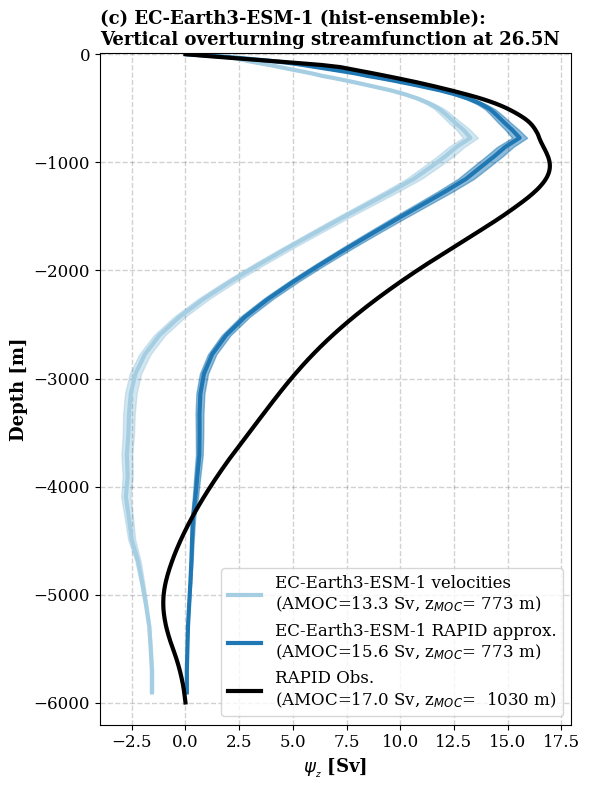

In [6]:
plot_streamfunctions(ds_mdl=ds_ecearth.sel(time=slice('2004-04', '2014-12')),
                     ds_obs=ds_obs_sf.sel(time=slice('2004-04', '2014-12')),
                     name="EC-Earth3-ESM-1 (hist-ensemble)"
                    )

In [7]:
def plot_volume_components(
    ds_mdl,
    ds_obs_vol=None,
    ds_obs_fc=None,
    name='simulated'
):
    """ Plot volume transport component time series """

    fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True, constrained_layout=True)

    # Panel a: Model
    axs[0].grid(True, lw=0.5, ls='--', color='k', alpha=0.3)

    fc_label = f'Florida Current = {(ds_mdl['fc'].mean(dim=["time", "ens"])).item():.1f} Sv'
    ek_label = f'Ekman = {(ds_mdl['ekman'].mean(dim=["time", "ens"])).item():.1f} Sv'
    umo_label = f'Upper-Mid Ocean = {(ds_mdl['umo'].mean(dim=["time", "ens"])).item():.1f} Sv'
    moc_label = f'AMOC = {(ds_mdl['moc_rapid'].mean(dim=["time", "ens"])).item():.1f} Sv'

    axs[0].plot(ds_mdl['time'], ds_mdl['fc'].mean(dim="ens"), linewidth=3, color="dodgerblue", label=fc_label)
    axs[0].fill_between(ds_mdl['time'],
                        y1=ds_mdl['fc'].mean(dim="ens")-ds_mdl['fc'].std(dim="ens"),
                        y2=ds_mdl['fc'].mean(dim="ens")+ds_mdl['fc'].std(dim="ens"),
                        color="dodgerblue", alpha=0.3)

    axs[0].plot(ds_mdl['time'], ds_mdl['ekman'].mean(dim="ens"), linewidth=3, color="coral", label=ek_label)
    axs[0].fill_between(ds_mdl['time'],
                        y1=ds_mdl['ekman'].mean(dim="ens")-ds_mdl['ekman'].std(dim="ens"),
                        y2=ds_mdl['ekman'].mean(dim="ens")+ds_mdl['ekman'].std(dim="ens"),
                        color="coral", alpha=0.3)

    axs[0].plot(ds_mdl['time'], ds_mdl['umo'].mean(dim="ens"), linewidth=3, color="purple", label=umo_label)
    axs[0].fill_between(ds_mdl['time'],
                        y1=ds_mdl['umo'].mean(dim="ens")-ds_mdl['umo'].std(dim="ens"),
                        y2=ds_mdl['umo'].mean(dim="ens")+ds_mdl['umo'].std(dim="ens"),
                        color="purple", alpha=0.3)

    axs[0].plot(ds_mdl['time'], ds_mdl['moc_rapid'].mean(dim="ens"), linewidth=3, color="0.1", label=moc_label)
    axs[0].fill_between(ds_mdl['time'],
                        y1=ds_mdl['moc_rapid'].mean(dim="ens")-ds_mdl['moc_rapid'].std(dim="ens"),
                        y2=ds_mdl['moc_rapid'].mean(dim="ens")+ds_mdl['moc_rapid'].std(dim="ens"),
                        color="0.1", alpha=0.3)

    axs[0].set_ylim([-60, 60])
    axs[0].set_ylabel('Volume Transport [Sv]', fontsize=13, fontweight='bold')
    axs[0].set_title(f'(c) {name}:\nVertical overturning components at 26.5N', loc='left', fontsize=12, fontweight='bold')
    axs[0].tick_params(axis='both', which='major', labelsize=12)
    axs[0].legend(loc=8, fontsize=12, ncol=2)


    # Add optional observational data to sub-axis
    if (ds_obs_vol is not None) or (ds_obs_fc is not None):

        # Panel b: observations
        axs[1].grid(True, lw=0.5, ls='--', color='k', alpha=0.3)
        if ds_obs_vol is not None:
            fc_obs_label = f'Florida Current = {(ds_obs_vol.t_gs10[~np.isnan(ds_obs_vol.t_gs10)].mean()).item():.1f} Sv'
            ek_obs_label = f'Ekman = {(ds_obs_vol.t_ek10[~np.isnan(ds_obs_vol.t_ek10)].mean()).item():.1f} Sv'
            umo_obs_label = f'Upper-Mid Ocean = {(ds_obs_vol.t_umo10[~np.isnan(ds_obs_vol.t_umo10)].mean()).item():.1f} Sv'
            moc_obs_label = f'AMOC = {(ds_obs_vol.moc_mar_hc10[~np.isnan(ds_obs_vol.moc_mar_hc10)].mean()).item():.1f} Sv'

            axs[1].plot(ds_obs_vol['time'], ds_obs_vol.t_gs10, linewidth=1.5, color="dodgerblue", alpha=0.4)
            t_gs10_monthly = ds_obs_vol.t_gs10.resample(time="1ME").mean()
            axs[1].plot(t_gs10_monthly['time'], t_gs10_monthly, linewidth=2.5, color="dodgerblue", label=fc_obs_label)

            axs[1].plot(ds_obs_vol['time'], ds_obs_vol.t_ek10, linewidth=1.5, color="coral", alpha=0.4)
            t_ek10_monthly = ds_obs_vol.t_ek10.resample(time="1ME").mean()
            axs[1].plot(t_ek10_monthly['time'], t_ek10_monthly, linewidth=2.5, color="coral", label=ek_obs_label)
    
            axs[1].plot(ds_obs_vol['time'], ds_obs_vol.t_umo10, linewidth=1.5, color="purple", alpha=0.4)
            t_umo10_monthly = ds_obs_vol.t_umo10.resample(time="1ME").mean()
            axs[1].plot(t_umo10_monthly['time'], t_umo10_monthly, linewidth=2.5, color="purple", label=umo_obs_label)

            axs[1].plot(ds_obs_vol['time'], ds_obs_vol.moc_mar_hc10, linewidth=1.5, color="0.1", alpha=0.4)
            moc_mar_hc10_monthly = ds_obs_vol.moc_mar_hc10.resample(time="1ME").mean()
            axs[1].plot(moc_mar_hc10_monthly['time'], moc_mar_hc10_monthly, linewidth=2.5, color="0.1", label=moc_obs_label)

        if ds_obs_fc is not None:
            fc_obs_ext_label = 'FC - extended (%6.1f Sv)' % (np.nanmean(ds_obs_fc.fc))
            axs[1].plot(ds_obs_fc.dates, ds_obs_fc.fc, linewidth=2, color=c4, label=fc_obs_ext_label)

        axs[1].set_xlabel('Time', fontsize=12, fontweight='bold')
        axs[1].set_ylim([-60, 60])
        axs[1].set_ylabel('Volume Transport [Sv]', fontsize=12, fontweight='bold')
        axs[1].set_title('(d) RAPID Observations:\nVertical overturning components at 26.5N', loc='left', fontsize=12, fontweight='bold')
        axs[1].tick_params(axis='both', which='major', labelsize=12)
        axs[1].legend(loc=8, fontsize=12, ncol=2)

    # Save plot
    plt.savefig("/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP4/figures/fig_EC-Earth3-ESM-1_moc_transports.png", dpi=800, bbox_inches="tight")
    

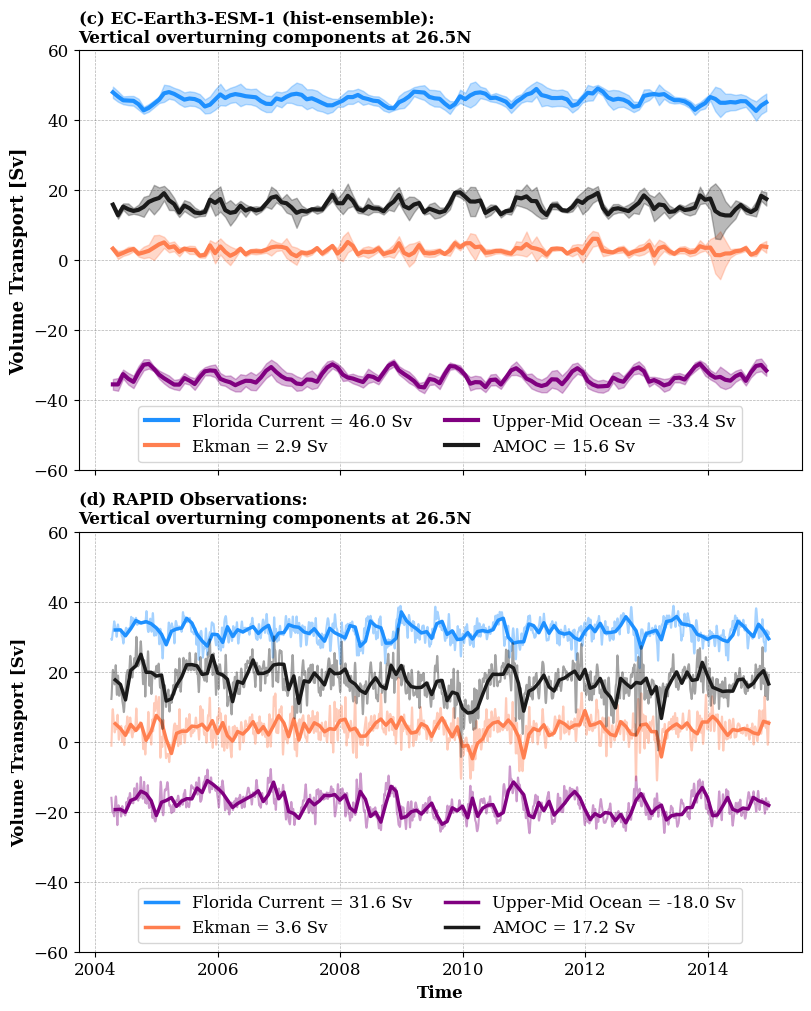

In [8]:
plot_volume_components(ds_mdl=ds_ecearth.sel(time=slice('2004-04', '2014-12')),
                       ds_obs_vol=ds_obs_vol.sel(time=slice('2004-04', '2014-12')),
                       name="EC-Earth3-ESM-1 (hist-ensemble)"
                      )


In [9]:
def plot_rapid_heat_components(ds_mdl, ds_obs_oht, name='Model'):
    """ Plot RAPID heat transport components """
    # Add model data to sub-axis
    fig = plt.figure(figsize=(8,10))
    fig.add_subplot(2,1,1)
    plt.grid(True, lw=0.5, ls='--', color='k', alpha=0.3)

    q_sum = ds_mdl['q_sum_rapid']
    q_ek = ds_mdl['q_ek']
    q_fc = ds_mdl['q_fc']
    q_geoint = ds_mdl['q_geoint']
    q_eddy = ds_mdl['q_eddy']
    q_wbw = ds_mdl['q_wbw']

    q_sum_label = f'Total = {q_sum.mean(dim=["time", "ens"]).item():.2f} PW'
    q_ek_label = f'Ekman = {q_ek.mean(dim=["time", "ens"]).item():.2f} PW'
    q_fc_label = f'Florida Current = {q_fc.mean(dim=["time", "ens"]).item():.2f} PW'
    q_geoint_label = f'Geostrophic Interior = {q_geoint.mean(dim=["time", "ens"]).item():.2f} PW'
    q_wbw_label = f'WBW = {q_wbw.mean(dim=["time", "ens"]).item():.2f} PW'
    q_eddy_label = f'Eddies = {q_eddy.mean(dim=["time", "ens"]).item():.2f} PW'

    plt.plot(ds_mdl['time'], q_sum.mean(dim="ens"), linewidth=3, color='k', label=q_sum_label)
    plt.fill_between(ds_mdl['time'],
                     y1=q_sum.mean(dim="ens")-q_sum.std(dim="ens"),
                     y2=q_sum.mean(dim="ens")+q_sum.std(dim="ens"),
                     color="k", alpha=0.3)

    plt.plot(ds_mdl['time'], q_ek.mean(dim="ens"), linewidth=3, color=c1, label=q_ek_label)
    plt.fill_between(ds_mdl['time'],
                     y1=q_ek.mean(dim="ens")-q_ek.std(dim="ens"),
                     y2=q_ek.mean(dim="ens")+q_ek.std(dim="ens"),
                     color=c1, alpha=0.3)

    plt.plot(ds_mdl['time'], q_fc.mean(dim="ens"), linewidth=3, color=c2, label=q_fc_label)
    plt.fill_between(ds_mdl['time'],
                     y1=q_fc.mean(dim="ens")-q_fc.std(dim="ens"),
                     y2=q_fc.mean(dim="ens")+q_fc.std(dim="ens"),
                     color=c2, alpha=0.3)

    plt.plot(ds_mdl['time'], q_wbw.mean(dim="ens"), linewidth=3, color=c3, label=q_wbw_label)
    plt.fill_between(ds_mdl['time'],
                     y1=q_wbw.mean(dim="ens")-q_wbw.std(dim="ens"),
                     y2=q_wbw.mean(dim="ens")+q_wbw.std(dim="ens"),
                     color=c3, alpha=0.3)

    plt.plot(ds_mdl['time'], q_geoint.mean(dim="ens"), linewidth=3, color=c4, label=q_geoint_label)
    plt.fill_between(ds_mdl['time'],
                     y1=q_geoint.mean(dim="ens")-q_geoint.std(dim="ens"),
                     y2=q_geoint.mean(dim="ens")+q_geoint.std(dim="ens"),
                     color=c4, alpha=0.3)

    plt.plot(ds_mdl['time'], q_eddy.mean(dim="ens"), linewidth=3, color='0.3', label=q_eddy_label)
    plt.fill_between(ds_mdl['time'],
                     y1=q_eddy.mean(dim="ens")-q_eddy.std(dim="ens"),
                     y2=q_eddy.mean(dim="ens")+q_eddy.std(dim="ens"),
                     color="0.3", alpha=0.3)

    plt.xlabel('Time', fontsize=12, fontweight='bold')
    plt.xticks(size=12)
    plt.ylabel('Ocean Heat Transport [PW]', fontsize=13, fontweight='bold')
    plt.yticks(size=12)
    plt.ylim([-5, 5])
    plt.title(f'(c) {name}:\nOcean Heat Transports relative to 0C at 26.5N', loc='left', fontsize=12, fontweight='bold')
    plt.legend(loc=8, fontsize=11, ncol=2)


    # Add observational data to sub-axis
    if ds_obs_oht is not None:
        fig.add_subplot(2,1,2)
        plt.grid(True, lw=0.5, ls='--', color='k', alpha=0.3)

        q_sum_obs_label = f'Total = {(ds_obs_oht.Q_sum.mean() / 1E15).item():.2f} PW'
        q_ek_obs_label = f'Ekman = {(ds_obs_oht.Q_ek.mean() / 1E15).item():.2f} PW'
        q_fc_obs_label = f'Florida Current = {(ds_obs_oht.Q_fc.mean() / 1E15).item():.2f} PW'
        q_geoint_obs_label = f'Geostrophic Interior = {(ds_obs_oht.Q_int.mean() / 1E15).item():.2f} PW'
        q_wbw_obs_label = f'WBW = {(ds_obs_oht.Q_wedge.mean() / 1E15).item():.2f} PW'
        q_eddy_obs_label = f'Eddies = {(ds_obs_oht.Q_eddy.mean() / 1E15).item():.2f} PW'

        plt.plot(ds_obs_oht.time, ds_obs_oht.Q_sum / 1E15, linewidth=1.5, color='k', alpha=0.4)
        Q_sum_monthly = (ds_obs_oht.Q_sum / 1E15).resample(time="1ME").mean()
        plt.plot(Q_sum_monthly.time, Q_sum_monthly, linewidth=2.5, color='k', label=q_sum_obs_label)

        plt.plot(ds_obs_oht.time, ds_obs_oht.Q_ek / 1E15, linewidth=1.5, color=c1, alpha=0.4)
        Q_ek_monthly = (ds_obs_oht.Q_ek / 1E15).resample(time="1ME").mean()
        plt.plot(Q_ek_monthly.time, Q_ek_monthly, linewidth=2.5, color=c1, label=q_ek_obs_label)

        plt.plot(ds_obs_oht.time, ds_obs_oht.Q_fc / 1E15, linewidth=1.5, color=c2, alpha=0.4)
        Q_fc_monthly = (ds_obs_oht.Q_fc / 1E15).resample(time="1ME").mean()
        plt.plot(Q_fc_monthly.time, Q_fc_monthly, linewidth=2.5, color=c2, label=q_fc_obs_label)

        plt.plot(ds_obs_oht.time, ds_obs_oht.Q_wedge / 1E15, linewidth=1.5, color=c3, alpha=0.4)
        Q_wedge_monthly = (ds_obs_oht.Q_wedge / 1E15).resample(time="1ME").mean()
        plt.plot(Q_wedge_monthly.time, Q_wedge_monthly, linewidth=2.5, color=c3, label=q_wbw_obs_label)

        plt.plot(ds_obs_oht.time, ds_obs_oht.Q_int / 1E15, linewidth=1.5, color=c4, alpha=0.4)
        Q_int_monthly = (ds_obs_oht.Q_int / 1E15).resample(time="1ME").mean()
        plt.plot(Q_int_monthly.time, Q_int_monthly, linewidth=2.5, color=c4, label=q_geoint_obs_label)

        plt.plot(ds_obs_oht.time, ds_obs_oht.Q_eddy / 1E15, linewidth=1.5, color='0.3', alpha=0.4)
        Q_eddy_monthly = (ds_obs_oht.Q_eddy / 1E15).resample(time="1ME").mean()
        plt.plot(Q_eddy_monthly.time, Q_eddy_monthly, linewidth=2.5, color='0.3', label=q_eddy_obs_label)

        plt.xlabel('Time', fontsize=13, fontweight='bold')
        plt.xticks(size=12)
        plt.ylabel('Ocean Heat Transport [PW]', fontsize=13, fontweight='bold')
        plt.yticks(size=12)
        plt.ylim([-5, 5])
        plt.title('(d) RAPID Observations:\nOcean Heat Transports relative to 0C at 26.5N', loc='left', fontsize=12, fontweight='bold')
        plt.legend(loc=8, fontsize=11, ncol=2)

    # Save plot
    plt.tight_layout()
    plt.savefig("/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP4/figures/fig_EC-Earth3-ESM-1_heat_transports.png", dpi=800, bbox_inches="tight")


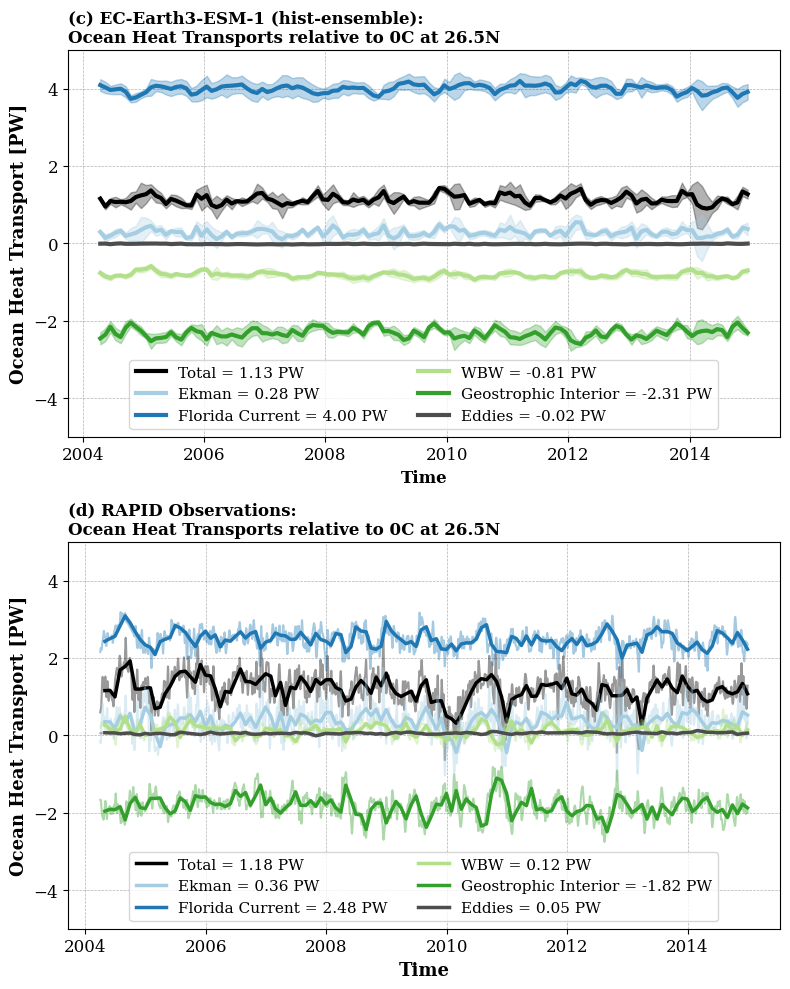

In [10]:
plot_rapid_heat_components(ds_mdl=ds_ecearth.sel(time=slice('2004-04', '2014-12')),
                           ds_obs_oht=ds_obs_oht.sel(time=slice('2004-04', '2014-12')),
                           name='EC-Earth3-ESM-1 (hist-ensemble)'
                           )

In [ ]:
def linreg(x,y,units='PW/Sv'):
    """ Return linear regression model and plot label """
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err =  stats.linregress(x,y)
        y_model = x * slope + intercept
        label = '(%5.3f %s)' % (slope, units)
    else:
        y_model = None
        label = ''

    return y_model, label

In [ ]:
def plot_moc_vs_oht(ds_mdl, ds_obs_vol=None, ds_obs_oht=None, name='Model'):
    """ Plot total overturning vs geometric heat transports """
    
    # Add model data to axis (model v)
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1,3,1)
    plt.grid(True, lw=0.5, ls='--', color='k', alpha=0.3)

    moc_model = ds_mdl['moc_model']
    q_sum_model = ds_mdl['q_sum_model']
    q_gyre_model = ds_mdl['q_gyre_model']
    q_ot_model = ds_mdl['q_ot_model']

    q_sum_model_lin, q_sum_model_label = linreg(moc_model, q_sum_model)
    q_gyre_model_lin, q_gyre_model_label = linreg(moc_model, q_gyre_model)
    q_ot_model_lin, q_ot_model_label = linreg(moc_model, q_ot_model)

    plt.plot(moc_model, q_sum_model,'x', color='k', label='Total %s' % q_sum_model_label)
    plt.plot(moc_model, q_ot_model,'x', color=c1, label='Overturning %s' % q_ot_model_label)
    plt.plot(moc_model, q_gyre_model,'x', color=c2, label='Gyre %s' % q_gyre_model_label)

    if q_sum_model_lin is not None:
        plt.plot(moc_model, q_sum_model_lin,'-', color='k')
        plt.plot(moc_model, q_ot_model_lin,'-', color=c1)
        plt.plot(moc_model, q_gyre_model_lin,'-', color=c2)

    plt.xlabel('AMOC [Sv]',fontsize=12, fontweight='bold')
    plt.ylabel('Ocean Heat Transport [PW]', fontsize=12, fontweight='bold')
    plt.title(f'(a) {name}:\nAMOC vs OHT (model velocities)', loc='left', fontsize=12, fontweight='bold')
    plt.legend(loc='best', fontsize=8, )


    # Add model data to axis (RAPID approx)
    fig.add_subplot(1,3,2)
    plt.grid(True, lw=0.5, ls='--', color='k', alpha=0.3)

    moc_rapid = ds_mdl['moc_rapid']
    q_sum_rapid = ds_mdl['q_sum_rapid']
    q_gyre_rapid = ds_mdl['q_gyre_rapid']
    q_ot_rapid = ds_mdl['q_ot_rapid']

    q_sum_rapid_lin, q_sum_rapid_label = linreg(moc_rapid, q_sum_rapid)
    q_gyre_rapid_lin, q_gyre_rapid_label = linreg(moc_rapid, q_gyre_rapid)
    q_ot_rapid_lin, q_ot_rapid_label = linreg(moc_rapid, q_ot_rapid)

    plt.plot(moc_rapid, q_sum_rapid,'x', color='k', label='Total %s' % q_sum_rapid_label)
    plt.plot(moc_rapid, q_ot_rapid,'x', color=c1, label='Overturning %s' % q_ot_rapid_label)
    plt.plot(moc_rapid, q_gyre_rapid,'x', color=c2, label='Gyre %s' % q_gyre_rapid_label)

    if q_sum_rapid_lin is not None:
        plt.plot(moc_rapid, q_sum_rapid_lin,'-', color='k')
        plt.plot(moc_rapid, q_ot_rapid_lin,'-', color=c1)
        plt.plot(moc_rapid, q_gyre_rapid_lin,'-', color=c2)

    plt.xlabel('AMOC [Sv]', fontsize=12, fontweight='bold')
    plt.ylabel('Ocean Heat transport [PW]', fontsize=12, fontweight='bold')
    plt.title(f'(b) {name}:\nAMOC vs OHT (RAPID approximation)', loc='left', fontsize=12, fontweight='bold')
    plt.legend(loc='best', fontsize=8, )


    # Add optional obs data to axis
    if ds_obs_oht is not None:
        fig.add_subplot(1,3,3)
        plt.grid(True, lw=0.5, ls='--', color='k', alpha=0.3)

        q_sum_obs = ds_obs_oht.Q_sum / 1E15
        q_gyre_obs = ds_obs_oht.Q_gyre / 1E15
        q_ot_obs = ds_obs_oht.Q_ot / 1E15
        moc_obs = ds_obs_oht.maxmoc

        q_sum_obs_lin, q_sum_obs_label = linreg(moc_obs, q_sum_obs)
        q_gyre_obs_lin, q_gyre_obs_label = linreg(moc_obs, q_gyre_obs)
        q_ot_obs_lin, q_ot_obs_label = linreg(moc_obs, q_ot_obs)

        plt.plot(moc_obs, q_sum_obs,'x', color='k', label='Total %s' % q_sum_obs_label)
        plt.plot(moc_obs, q_ot_obs,'x', color=c1, label='Overturning %s' % q_ot_obs_label)
        plt.plot(moc_obs, q_gyre_obs,'x', color=c2, label='Gyre %s' % q_gyre_obs_label)

        if q_sum_obs_lin is not None:
            plt.plot(moc_obs, q_sum_obs_lin,'-', color='k')
            plt.plot(moc_obs, q_ot_obs_lin,'-', color=c1)
            plt.plot(moc_obs, q_gyre_obs_lin,'-', color=c2)

        plt.xlabel('AMOC [Sv]', fontsize=12, fontweight='bold')
        plt.ylabel('Ocean Heat transport [PW]', fontsize=12, fontweight='bold')
        plt.title(f'(c) RAPID Observations:\nAMOC vs OHT', loc='left', fontsize=12, fontweight='bold')
        plt.legend(loc='best', fontsize=8, )

    # Save plot
    plt.tight_layout()

In [ ]:
plot_moc_vs_oht(ds_mdl=ds_r1.sel(time=slice('2004-04', '2014-12')),
                ds_obs_vol=None, ds_obs_oht=ds_mht.sel(time=slice('2004-04', '2014-12')),
                name='EC-Earth'
                )

In [ ]:
def plot_streamfunction_hovmollers(
    ds_mdl,
    ds_obs=None,
    name='Model'
):
    """ Plot overturning stream function hovmoller diagrams"""

    # Extract variables from data objects
    sf_rapid = ds_mdl['sf_rapid']
    sf_model = ds_mdl['sf_model']

   # Set up figure
    fig = plt.figure(figsize=(8,12))
    cmap=plt.cm.viridis
    levels = np.arange(15) * 2 - 4
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # Add model data to axis
    fig.add_subplot(3,1,1)
    plt.pcolormesh(sf_model["time"], -sf_model["z"], sf_model.transpose(), shading='nearest', cmap=cmap, norm=norm)
    plt.colorbar(orientation='vertical')
    plt.title(f"(a) {name} velocities:\nVertical overturning streamfunction at 26.5N", loc='left', fontsize=12, fontweight='bold')
    plt.xlabel('Time', fontsize=12, fontweight='bold')
    plt.ylabel('Depth [m]', fontsize=12, fontweight='bold')

    # Add model data to axis (RAPID approx)
    fig.add_subplot(3,1,2)
    plt.pcolormesh(sf_rapid["time"], -sf_rapid["z"], sf_rapid.transpose(), shading='nearest', cmap=cmap, norm=norm)
    plt.colorbar(orientation='vertical')
    plt.title(f"(b) {name} RAPID approximation:\nVertical overturning streamfunction at 26.5N", loc='left', fontsize=12, fontweight='bold')
    plt.xlabel('Time', fontsize=12, fontweight='bold')
    plt.ylabel('Depth [m]', fontsize=12, fontweight='bold')

    # Add optional observed data to axis
    if ds_obs is not None:
        fig.add_subplot(3,1,3)
        plt.pcolormesh(ds_obs['time'], -ds_obs['depth'], ds_obs.stream_function_mar, shading='nearest', cmap=cmap, norm=norm)
        plt.colorbar(orientation='vertical')
        plt.title('(c) RAPID Observations:\nVertical overturning streamfunction at 26.5N', loc='left', fontsize=12, fontweight='bold')
        plt.xlabel('Time', fontsize=12, fontweight='bold')
        plt.ylabel('Depth [m]', fontsize=12, fontweight='bold')

    # Save plot
    plt.tight_layout()

In [ ]:
plot_streamfunction_hovmollers(ds_mdl=ds_r1.sel(time=slice('2004-04', '2014-12')),
                               ds_obs=ds_moc_vertical.sel(time=slice('2004-04', '2014-12')),
                               name="EC-Earth3-ESM-1 (hist-ensemble)"
                              )